# My data

In [1]:
import torch
import numpy as np
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis
from torch.distributions import Uniform
from sbi.utils import MultipleIndependent
from torch import tensor
import pickle
import pandas as pd
import sys
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import moment
from fecundity.simulator import simulator
import json

#### Check data and store in summary stats in observations.npy

In [2]:
res_len = 5
census_yr_vec = [2,6,8,11,14]
observations = np.empty(5*3)

fn = 'observations/density.csv'
densities_o = pd.read_csv(fn, header=None)
densities_o[0] = [round(v) for v in densities_o[0]]
census_yrs = densities_o[0].to_list()
print([census_yrs.count(v) for v in np.unique(census_yrs)])

fn = 'observations/mortality_avg.csv'
mort_o = pd.read_csv(fn, header=None)
mort_o[0] = [round(v) for v in mort_o[0]]
observations[0:res_len] = mort_o[1].to_numpy()

fn = 'observations/mortality.csv'
mort_o = pd.read_csv(fn, header=None)
mort_o[0] = [round(v) for v in mort_o[0]]
census_yrs = mort_o[0].to_list()
print([census_yrs.count(v) for v in np.unique(census_yrs)])
observations[res_len:res_len*2] = [mort_o[mort_o[0] == yr][1].to_numpy().min() for yr in census_yr_vec]
observations[res_len*2:res_len*3] = [mort_o[mort_o[0] == yr][1].to_numpy().max() for yr in census_yr_vec]

np.save('observations/observations.npy', observations)

[11, 13, 11, 8, 9, 9]
[11, 13, 13, 11, 9]


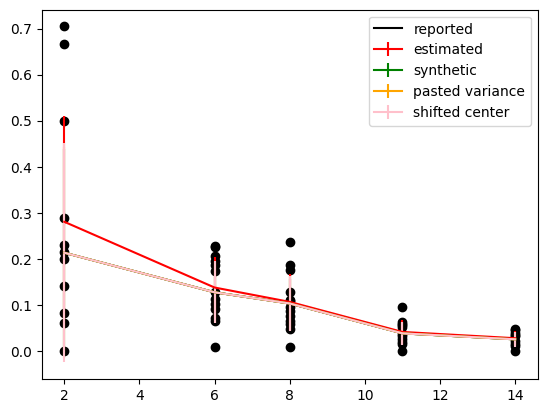

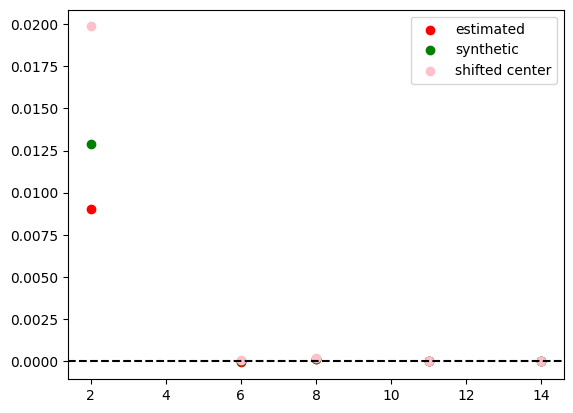

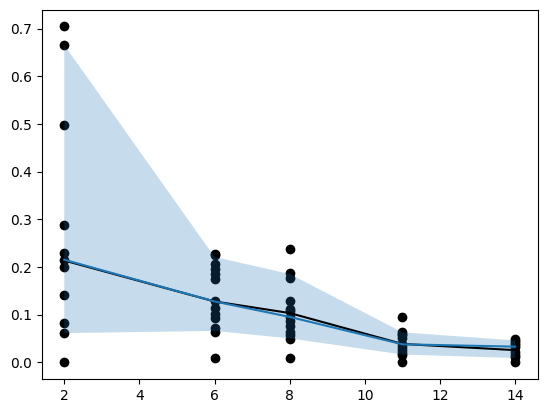

In [37]:
fn = 'observations/mortality.csv'
mortality_o = pd.read_csv(fn, header=None)
mortality_o[0] = [round(v) for v in mortality_o[0]]
plt.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')
fn = 'observations/mortality_avg.csv'
mortality_avg_o = pd.read_csv(fn, header=None)
mortality_avg_o[0] = [round(v) for v in mortality_avg_o[0]]
plt.plot(mortality_avg_o[0].to_numpy(), mortality_avg_o[1].to_numpy(), color='k', label='reported')

census_yrs = [2,6,8,11,14]
m1 = []; m2 = []; m3 = []
m1_adj = []; m2_adj = []; m3_adj = []
m2_shft = []; m3_shft = []
for t_i, t in enumerate(census_yrs):
    mort_sub = mortality_o[mortality_o[0]==t][1].to_numpy()
    est_mean = np.mean(mort_sub)
    m1.append(est_mean)
    m2.append(moment(mort_sub, moment=2))
    m3.append(moment(mort_sub, moment=3))
    # Add 'synthetic' data point to get estimated avg to match reported
    # synthetic = (len(mort_sub) + 1) * (mortality_avg_o[1][t_i]) - np.sum(mort_sub)
    # mort_sub_adj = np.append(mort_sub, [synthetic])
    num_synth = 4  #need at least 4 to make synthetic point non-negative
    synthetic = ((len(mort_sub) + num_synth) * (mortality_avg_o[1][t_i]) - np.sum(mort_sub)) / num_synth
    mort_sub_adj = np.append(mort_sub, np.repeat(synthetic, num_synth))
    # print(synthetic)
    m1_adj.append(np.mean(mort_sub_adj))
    m2_adj.append(moment(mort_sub_adj, moment=2))
    m3_adj.append(moment(mort_sub_adj, moment=3))
    # Try computing higher moments assuming reported average
    m2_shft.append(moment(mort_sub, moment=2, center=mortality_avg_o[1][t_i]))
    m3_shft.append(moment(mort_sub, moment=3, center=mortality_avg_o[1][t_i]))
plt.errorbar(census_yrs, m1, yerr=np.sqrt(m2), color='r', label='estimated')
plt.errorbar(census_yrs, m1_adj, yerr=np.sqrt(m2_adj), color='g', label='synthetic')  #std below zero
plt.errorbar(census_yrs, mortality_avg_o[1].to_numpy(), yerr=np.sqrt(m2), color='orange', label='pasted variance') #std below zero
plt.errorbar(census_yrs, mortality_avg_o[1].to_numpy(), yerr=np.sqrt(m2_shft), color='pink', label='shifted center') #std below zero
plt.legend()
plt.show()
plt.scatter(census_yrs, m3, c='r', label='estimated')
plt.scatter(census_yrs, m3_adj, c='g', label='synthetic')
plt.scatter(census_yrs, m3_shft, c='pink', label='shifted center')
plt.axhline(0, ls='--', color='k')
plt.legend()
plt.show()
plt.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')
plt.plot(mortality_avg_o[0].to_numpy(), mortality_avg_o[1].to_numpy(), color='k')
mort_subs = [mortality_o[mortality_o[0]==t][1].to_numpy() for t in census_yrs]
percentiles = np.empty((2, len(census_yrs)))
percentiles[0] = [np.percentile(ms, 10) for ms in mort_subs]
percentiles[1] = [np.percentile(ms, 90) for ms in mort_subs]
medians = [np.median(ms) for ms in mort_subs]
plt.plot(census_yrs, medians)
# plt.errorbar(census_yrs, medians, yerr=percentiles)
plt.fill_between(census_yrs, percentiles[0], percentiles[1], alpha=0.25)

In [152]:
# Save new summary stats to observations.npy
# observations = np.concatenate((m1,m2,m3))
# np.save('observations/observations.npy', observations)

#### Playing with parameters

In [2]:
def simulator(params):
    # Assign parameter labels
    alph_m = params[0]; beta_m = params[1]; gamm_m = params[2]
    sigm_m = params[3]; tau_m = params[4]
    alph_nu = params[5]; beta_nu = params[6]; gamm_nu = params[7]
    K_seedling = params[8]; kappa = params[9]; K_adult = params[10]
    eta = params[11]
    mu_m = params[12]

    # For generating env stochasticity multipliers
    rng = np.random.default_rng()

    # Initialize empty results array
    census_yrs = np.array([1,2,6,8,11,14])
    res_len = len(census_yrs) - 1
    results = np.empty(res_len * 3)
    res_i = 0

    t_vec = np.arange(1,15)
    fn = 'mortality/observations/density.csv'
    densities_o = pd.read_csv(fn, header=None)
    densities_o[0] = [round(v) for v in densities_o[0]]
    N_0_1 = densities_o[densities_o[0] == 1][1].to_numpy()
    N_vec = np.ma.array(np.zeros((len(N_0_1), len(t_vec))))
    N_vec[:,0] = N_0_1
    N_vec = N_vec.astype(int)
    census_init = N_vec.sum(axis=1)
    census_yr_init = t_vec[0]

    m_a = alph_m * np.exp(-beta_m*t_vec) + gamm_m
    K_a = K_seedling * np.exp(-kappa*t_vec) + K_adult
    # K_a = K_adult
    nu_a = alph_nu * np.exp(-beta_nu*t_vec) + gamm_nu

    for age_i, t in enumerate(t_vec[:-1]):
        for pop_i, N_pop in enumerate(N_vec):
            # If pop already extirpated, skip
            if (np.ma.is_masked(N_vec)) and (np.ma.getmask(N_vec)[pop_i, 0]):
                continue
            # Add density dependent term to mortalities
            dens_dep = ((nu_a)*(1-m_a)) / (1 + np.exp(-eta*K_adult*(np.sum(N_pop/K_a) - 1)))
            m_a_N = m_a + dens_dep
            # Draw env. stoch. terms and combine for final survival prob.
            epsilon_m = rng.lognormal(np.zeros_like(t_vec)+mu_m, sigm_m*np.exp(-tau_m*t_vec))
            survival_probs = np.exp(-m_a_N * epsilon_m)
            num_survivors = rng.binomial(N_pop, survival_probs)
            num_survivors = np.roll(num_survivors, 1)
            # Finally, update abundances
            N_vec[pop_i] = num_survivors
            # Note if population was extirpated
            if np.sum(num_survivors) == 0:
                N_vec[pop_i, :] = np.ma.masked
                census_init[pop_i] = np.ma.masked
        # If enough populations extirpated, consider parameter set invalid
        if (np.ma.is_masked(N_vec)) and (sum(np.ma.getmask(N_vec)[:,0]) > 3):
            results[0:res_len] = np.ones(len(census_yrs)-1)*10
            results[res_len:res_len*2] = np.ones(len(census_yrs)-1)*20
            results[res_len*2:res_len*3] = np.ones(len(census_yrs)-1)*20
            break
        elif t+1 in census_yrs:
            # Calculate and store mortality stats
            delta_t = (t+1) - census_yr_init
            census_final = N_vec.sum(axis=1)
            mortality = ((census_init - census_final) / census_init) / delta_t
            results[res_i] = np.mean(mortality)
            results[res_len + res_i] = moment(mortality, moment=2)
            results[res_len*2 + res_i] = moment(mortality, moment=3)
            # Reset for next census
            res_i += 1
            census_init = census_final
            census_yr_init = t+1
    return results

In [46]:
def plt_sim(alph_m = 0.9, beta_m = 0.35, gamm_m = 0.03,
            sigm_m = 0.1, tau_m = 0.02,
            alph_nu = 0.6185, beta_nu = 0.189, gamm_nu = 0.088,
            K_seedling=60000, kappa = 0.4, K_adult = 1024*10, mu_m = 0.0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    census_yrs = [2,6,8,11,14]
    fn = 'mortality/observations/mortality.csv'
    mortality_o = pd.read_csv(fn, header=None)
    mortality_o[0] = [round(v) for v in mortality_o[0]]
    m1 = []; m2 = []; m3 = []
    for t_i, t in enumerate(census_yrs):
        mort_sub = mortality_o[mortality_o[0]==t][1].to_numpy()
        est_mean = np.mean(mort_sub)
        m1.append(est_mean)
        m2.append(moment(mort_sub, moment=2))
        m3.append(moment(mort_sub, moment=3))
    ax1.errorbar(census_yrs, m1, yerr=np.sqrt(m2), color='k', fmt='o')
    
    params = [alph_m, beta_m, gamm_m, sigm_m, tau_m, alph_nu, 
              beta_nu, gamm_nu, K_seedling, kappa, K_adult, 0.0005, mu_m] #Hardcoding in eta bc interact can't handle very low numbers
    reps = 100
    num_invalid = 0
    all_res = np.zeros((reps,3*5))
    for rep in range(reps):
        res = simulator(params)
        if np.all(res[0:5] == 10):
            num_invalid += 1
            continue
        all_res[rep] = res
    all_res = np.delete(all_res, -num_invalid, axis=0)
    res = np.mean(all_res, axis=0)
    print('{} sims with >3 extirpations'.format(num_invalid))
    plt.axhline(0, ls='--', color='k')
    ax1.scatter(census_yrs, res[0:5], c='magenta', alpha=0.75)
    ax1.fill_between(census_yrs, res[0:5]-np.sqrt(res[5:10]), res[0:5]+np.sqrt(res[5:10]), color='magenta', alpha=0.2)
    ax1.set_ylim(-0.1,0.8)
    
    ax2.scatter(census_yrs, m3, c='k')
    ax2.scatter(census_yrs, res[10:15], alpha=0.75, c='magenta')
    
# defaults = np.array([0.1981,0.2498,0.03,1.1528,0.02,0.2678,0.189,0.088,6000*10,0.3,1024*10,0.1,0.0])
# defaults = np.array([0.1981, 0.2498, 1.1528, 0.2678])
# defaults = {"gamm_m": 0.01, "tau_m": 0.01, "mu_m": 0.0, "alph_nu": 0.0, "beta_nu": 0.25, "K_seedling": 50000, "K_adult": 16000, "kappa": 0.4, "eta": 0.0005, "alph_m": 0.20839876927344037, "beta_m": 0.28271061933785363, "sigm_m": 1.180197985613292, "gamm_nu": 0.31477250642960225}
# defaults = {"gamm_m": 0.01, "tau_m": 0.01, "mu_m": 0.0, "alph_nu": 0.0, "beta_nu": 0.25, "K_seedling": 60000, "K_adult": 10000, "eta": 0.0005, "alph_m": 0.11923600610476123, "beta_m": 0.4503193391540052, "sigm_m": 0.8436692122683228, "gamm_nu": 0.5445031101471397, "kappa": 1.1389208123467265}
# Read in map parameters
defaults = {}
with open('../model_fitting/mortality/map.json', 'r') as handle:
    defaults.update(json.load(handle)) 
interact(plt_sim,
         alph_m = widgets.FloatSlider(value=defaults['alph_m'], min=0.01, max=0.6, step=0.01, continuous_update=False),
         beta_m = widgets.FloatSlider(value=defaults['beta_m'], min=0.01, max=0.6, step=defaults['beta_m']/40, continuous_update=False),
         gamm_m = widgets.FloatSlider(value=defaults['gamm_m'], min=defaults['gamm_m']*0.25, max=defaults['gamm_m']*1.75, step=defaults['gamm_m']/40, continuous_update=False),
         sigm_m = widgets.FloatSlider(value=defaults['sigm_m'], min=0., max=1.7, step=defaults['sigm_m']/40, continuous_update=False),
         tau_m = widgets.FloatSlider(value=defaults['tau_m'], min=0.0, max=0.4, step=defaults['tau_m']/40, continuous_update=False),
         alph_nu = widgets.FloatSlider(value=defaults['alph_nu'], min=0.0, max=3, step=0.01, continuous_update=False),
         beta_nu = widgets.FloatSlider(value=defaults['beta_nu'], min=defaults['beta_nu']*0.25, max=0.75, step=defaults['beta_nu']/40, continuous_update=False),
         gamm_nu = widgets.FloatSlider(value=defaults['gamm_nu'], min=defaults['gamm_nu']*0.25, max=0.8, step=defaults['gamm_nu']/40, continuous_update=False),
         K_seedling = widgets.FloatSlider(value=defaults['K_seedling'], min=20000, max=160000, step=10, continuous_update=False),
         kappa = widgets.FloatSlider(value=defaults['kappa'], min=0.01, max=2.5, step=0.01, continuous_update=False),
         K_adult = widgets.FloatSlider(value=defaults['K_adult'], min=defaults['K_adult']*0.25, max=60000, step=10, continuous_update=False),
         # eta = widgets.FloatSlider(value=defaults['eta'], min=0.01, max=0.6, step=defaults['eta']/40, continuous_update=False),
         mu_m = widgets.FloatSlider(value=defaults['mu_m'], min=-0.2, max=0.1, step=0.01, continuous_update=False))

interactive(children=(FloatSlider(value=0.12080289604671729, continuous_update=False, description='alph_m', ma…

<function __main__.plt_sim(alph_m=0.9, beta_m=0.35, gamm_m=0.03, sigm_m=0.1, tau_m=0.02, alph_nu=0.6185, beta_nu=0.189, gamm_nu=0.088, K_seedling=60000, kappa=0.4, K_adult=10240, mu_m=0.0)>

#### posterior pairplot

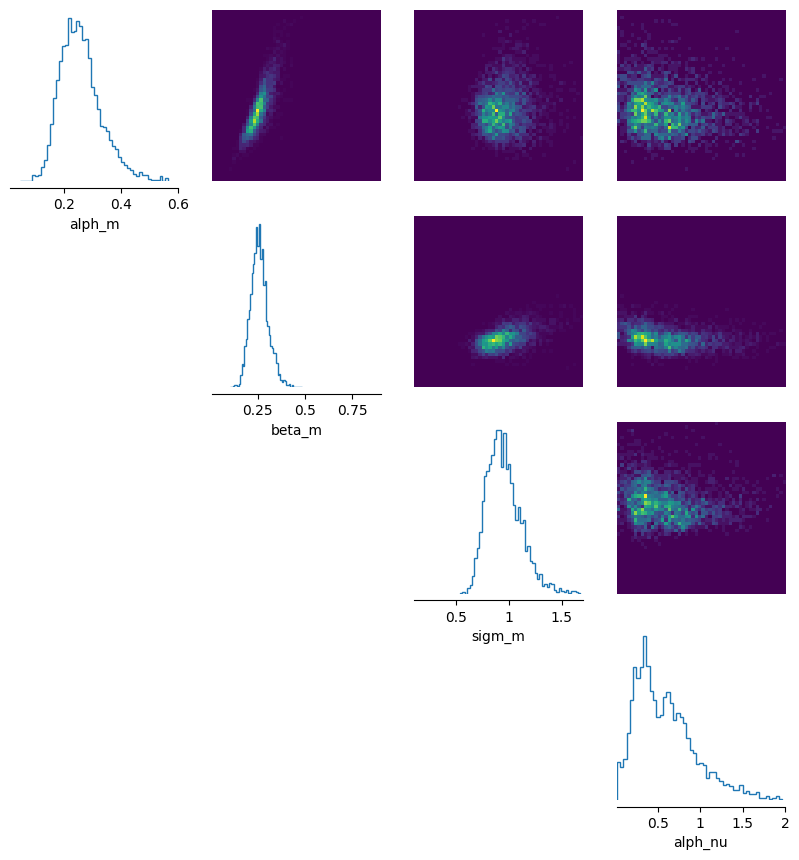

In [10]:
limits = [[0.01, 0.6], [0.01, 0.9], [0.1,1.7], [0.01,2.]]
labels = ['alph_m', 'beta_m', 'sigm_m','alph_nu']
nle_samples = torch.load('posterior_samples_test.pkl')
_ = analysis.pairplot(
    nle_samples, limits=limits, figsize=(10, 10), labels=labels
)

#### restricted prior pairplot

In [4]:
with open('fecundity/restricted_prior.pkl', 'rb') as handle:
    restricted_prior = pickle.load(handle)

The `RestrictedPrior` rejected 0.9%
                of prior samples. You will get a speed-up of
                0.9%.


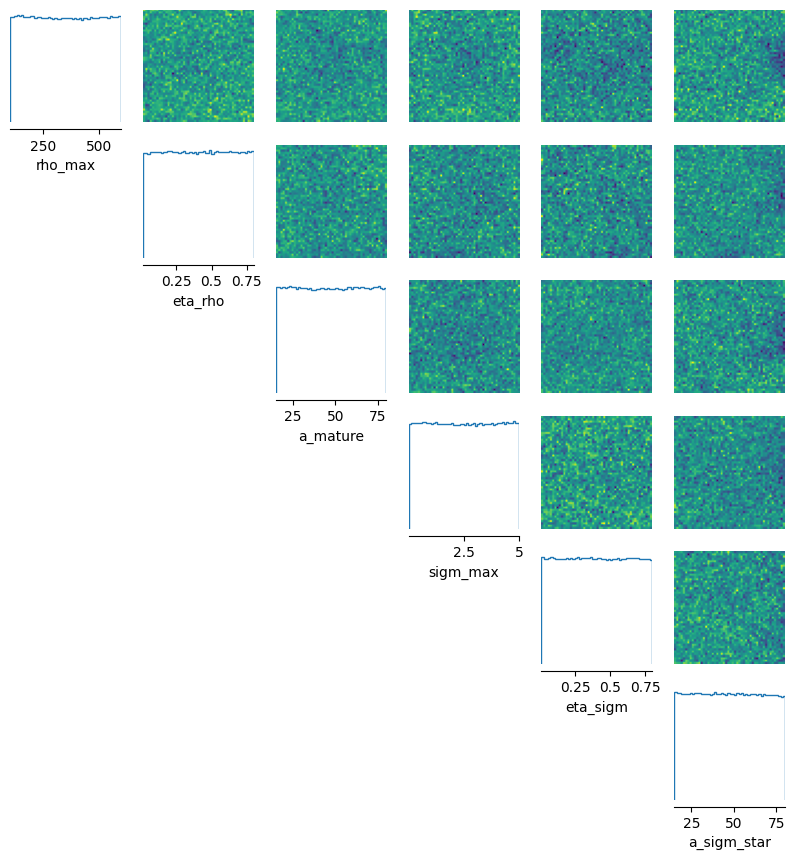

In [5]:
limits = np.array([
                   [100, 600],
                   [0.01, 0.8],
                   [15, 80],
                   [0.01, 5],
                   [0.01, 0.8],
                   [15, 80]
])
labels = ['rho_max', 'eta_rho', 'a_mature', 'sigm_max', 'eta_sigm', 'a_sigm_star']
prior_samples = restricted_prior.sample((1_000_000,))
_ = analysis.pairplot(
    prior_samples, limits=limits, figsize=(10, 10), labels=labels
)

The `RestrictedPrior` rejected 0.5%
                of prior samples. You will get a speed-up of
                0.5%.


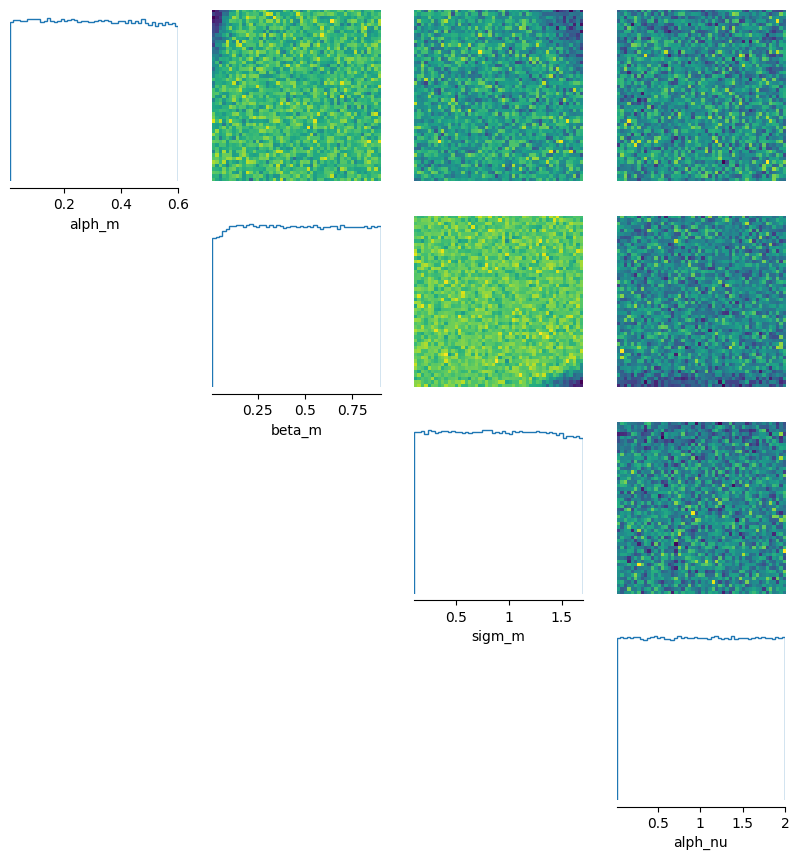

In [8]:
limits = [[0.01, 0.6], [0.01, 0.9], [0.1,1.7], [0.01,2.]]
labels = ['alph_m', 'beta_m', 'sigm_m','alph_nu']
prior_samples = restricted_prior.sample((1_000_000,))
_ = analysis.pairplot(
    prior_samples, limits=limits, figsize=(10, 10), labels=labels
)

#### posterior validation

In [2]:
params = [600, 0.22, 15., 5., 0.4, 46]
simulator(params)

array([nan, nan, nan, nan, nan, nan, nan])

In [3]:
pr = 'fecundity'

In [3]:
with open(pr+'/prior.pkl', 'rb') as handle:
    prior = pickle.load(handle)
prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)
simulator = utils.user_input_checks.process_simulator(simulator, prior, is_numpy_simulator=True)

In [4]:
x_o = np.load(pr+'/observations/observations.npy')
x_o = torch.Tensor(x_o)
with open(pr+"/posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)

In [18]:
posterior.map(force_update=True, num_init_samples=10_000)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[202.7345,   0.4350,  32.9950,   0.7621,   0.5823]],
       dtype=torch.float64)

In [8]:
_map = posterior.map(force_update=True).numpy()[0]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
_map

array([202.72823654,   0.43497872,  32.99502173,   0.76202065,
         0.58233001])

In [14]:
posterior.map(num_iter=10_000, num_init_samples=10_000, num_to_optimize=1_000, force_update=True)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[0.1981, 0.2498, 1.1527, 0.2678]], dtype=torch.float64)

##### ppc

In [6]:
posterior_samples = posterior.sample(sample_shape=(1000,))
x_pp = simulator(posterior_samples)
# theta_pp, x_pp = simulate_for_sbi(simulator, proposal=prior, num_simulations=10_000, num_workers=8)
x_pp = x_pp[~torch.any(x_pp.isnan(),dim=1)]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
lim_scale = 1.0
mins = x_pp.amin(0)
maxes = x_pp.amax(0)
limits = torch.tensor([[mins[i]*lim_scale, maxes[i]*lim_scale] for i in range(x_pp.shape[1])])
limits[9][0] = -0.0005; limits[9][1] = 0.001
limits[12][0] = -0.0005; limits[12][1] = 0.0008
limits[13][0] = -0.00005; limits[13][1] = 0.00015
limits[14][0] = -0.00005; limits[14][1] = 0.0001

In [9]:
with open(pr+'/x_pp.pkl', 'rb') as handle:
    x_pp = pickle.load(handle)

(0.0, 0.2)

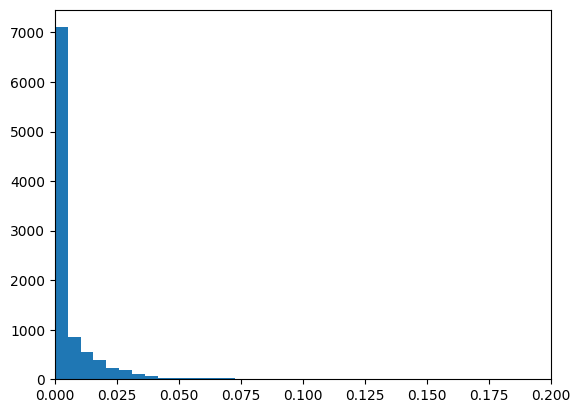

In [19]:
hist = plt.hist(x_pp[:,6].numpy(), bins=10000);
# hist = plt.hist(x_pp[:,6].numpy());
plt.xlim(0,0.2)

In [16]:
hist

(array([9.388e+03, 1.500e+01, 8.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([6.58815225e-11, 8.34865570e+01, 1.66973114e+02, 2.50459686e+02,
        3.33946228e+02, 4.17432800e+02, 5.00919373e+02, 5.84405945e+02,
        6.67892456e+02, 7.51379028e+02, 8.34865601e+02]),
 <BarContainer object of 10 artists>)

In [10]:
mins = x_pp.amin(0)
maxes = x_pp.amax(0)
limits = torch.tensor([[mins[i], maxes[i]] for i in range(x_pp.shape[1])])
limits[0][0] = -0.0005; limits[0][1] = 10
limits[1][0] = -0.0005; limits[1][1] = 250
limits[2][0] = -0.0005; limits[2][1] = 2500
limits[3][0] = -0.0005; limits[3][1] = 10
limits[4][0] = -0.0005; limits[4][1] = 250
limits[5][0] = -0.0005; limits[5][1] = 2500
limits[6][0] = -0.0005; limits[6][1] = 0.4

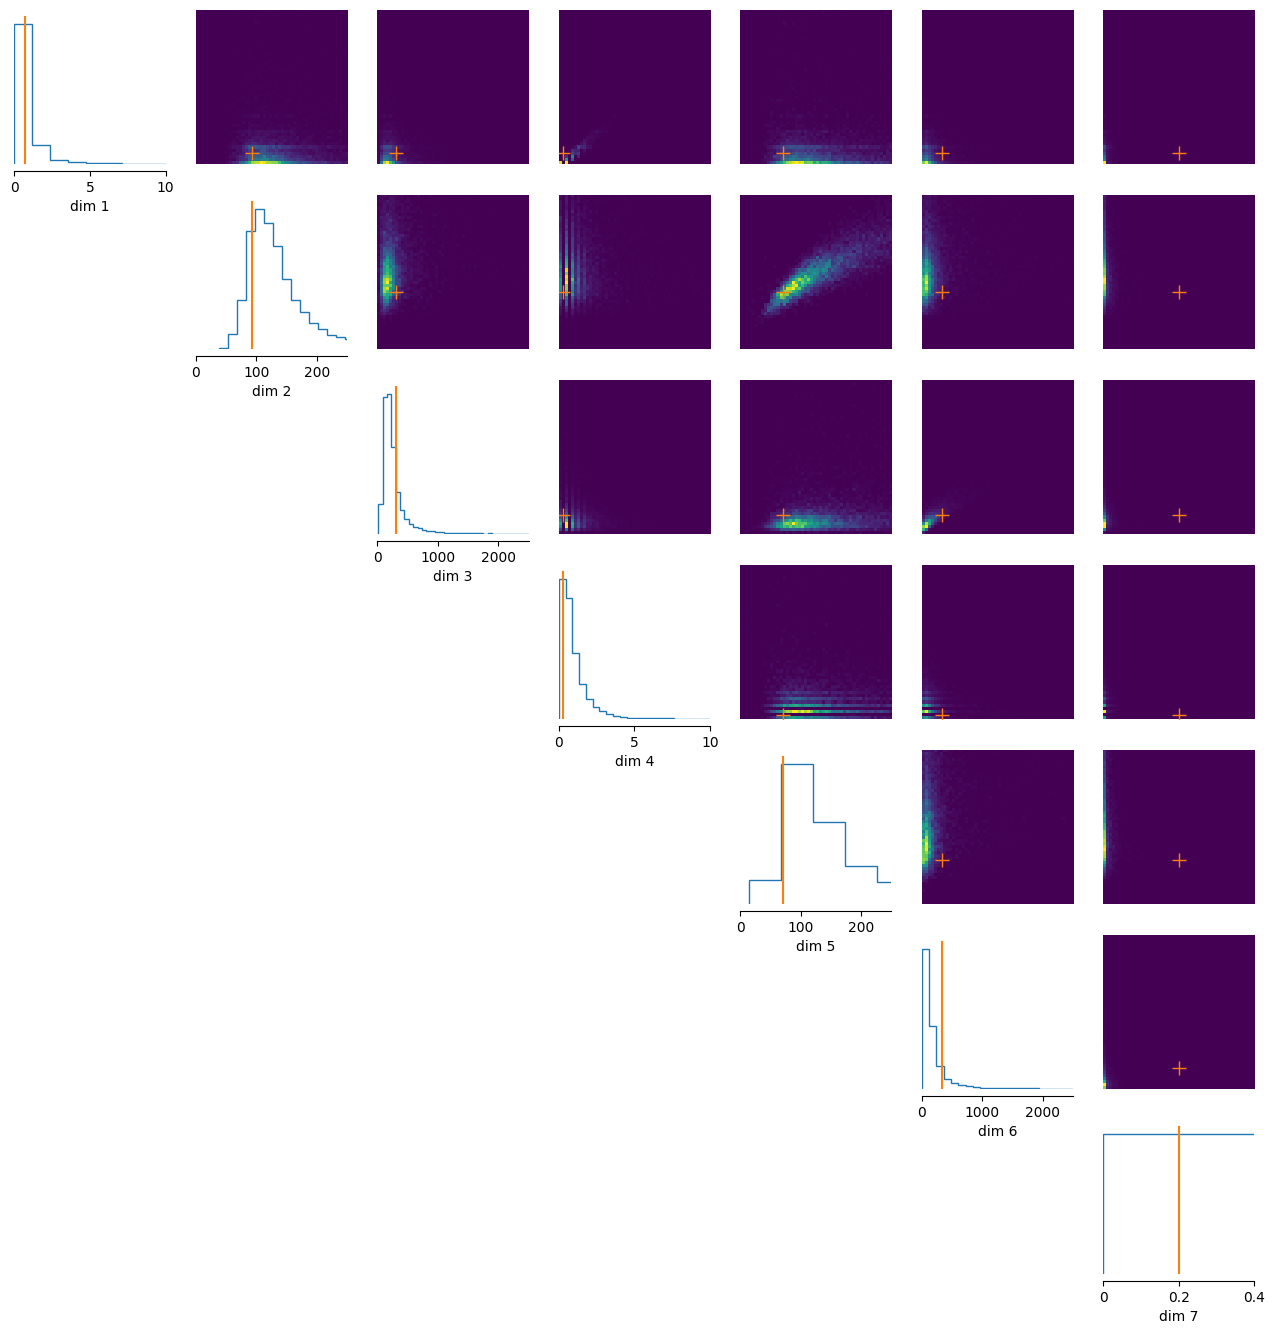

In [11]:
ppc = analysis.pairplot(
    samples=x_pp,
    points=x_o, 
    points_offdiag=dict(marker="+", markersize=10),
    limits=limits,
    figsize=(16,16)
)
# ppc[0].savefig('sbi_figs/npe_ppc.png', bbox_inches='tight')

##### sbc

In [8]:
from sbi.diagnostics import check_sbc, run_sbc

In [13]:
with open("prior.pkl", "rb") as handle:
    prior = pickle.load(handle)
# prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)
simulator = utils.user_input_checks.process_simulator(simulator, prior, is_numpy_simulator=True)


with open("posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)

num_simulations = 1000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
#thetas = prior.sample((num_simulations,))
#xs = simulator(thetas)
thetas, xs = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_simulations, num_workers=6)
# filter out invalid parameter samples
thetas = thetas[~torch.any(xs.isnan(),dim=1)]
xs = xs[~torch.any(xs.isnan(),dim=1)]

num_posterior_samples = 100_000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples,
    num_workers=6, reduce_fns=posterior.log_prob,
)

check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 978 sbc runs in 978
                    batches.:   0%|          | 0/978 [00:00<?, ?it/s]

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [0.0003062]
c2st accuracies 
check_stats['c2st_ranks'] = [0.50563836]
- c2st accuracies check_stats['c2st_dap'] = [0.5076387  0.5214703  0.5010152  0.51277727]


In [4]:
with open('sbc_stats.pkl', 'rb') as handle:
    sbc_stats = pickle.load(handle)

In [6]:
sbc_stats

{'ks_pvals': tensor([9.3758e-04, 3.1248e-11, 3.6588e-05, 4.8139e-07]),
 'c2st_ranks': tensor([0.6956, 0.6899, 0.6917, 0.6842]),
 'c2st_dap': tensor([0.5016, 0.5068, 0.5007, 0.4968])}

In [12]:
with open('ranks.pkl', 'rb') as handle:
    ranks = pickle.load(handle)
num_posterior_samples = 100_000

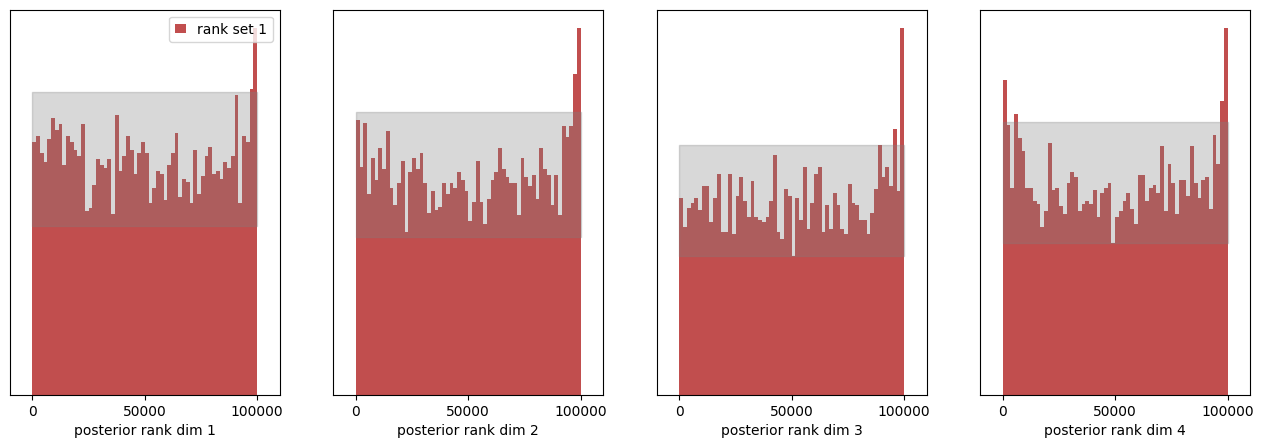

In [35]:
f, ax = analysis.plot.sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=60,  # by passing None we use a heuristic for the number of bins.
)

In [19]:
f.savefig('figs/rank_hist.png', bbox_inches='tight')

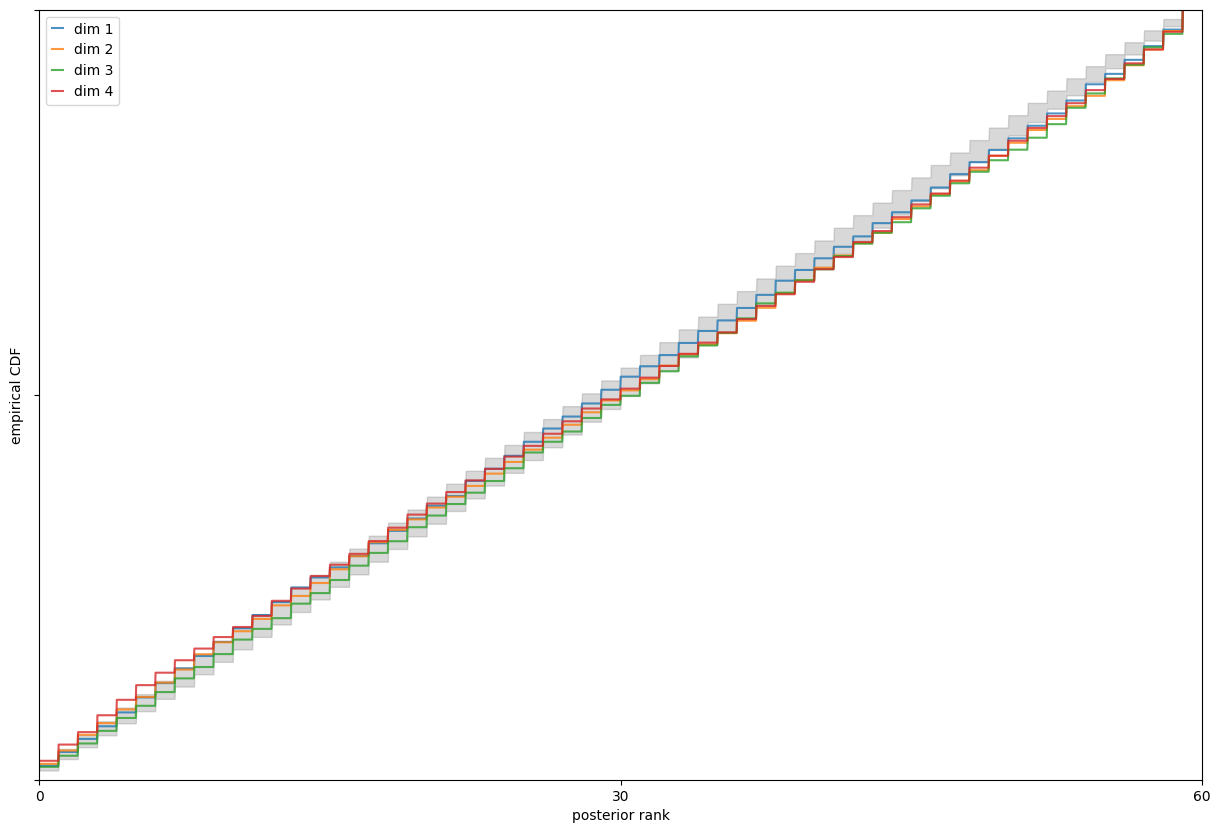

In [38]:
f, ax = analysis.plot.sbc_rank_plot(ranks, 100_000, plot_type="cdf", num_bins=60, figsize=(15,10))

In [22]:
f.savefig('figs/rank_cdf.png', bbox_inches='tight')

In [22]:
import psutil
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total

39.32943344116211